In [153]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
from PIL import Image, ImageCms
import matplotlib.pyplot as plt
from torch import nn, optim
import torch
import random
import cv2
import numpy as np

253 161 209


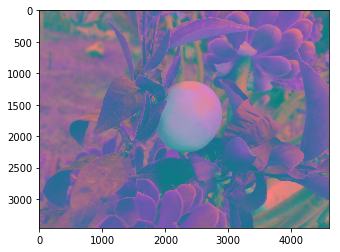

255 255 255


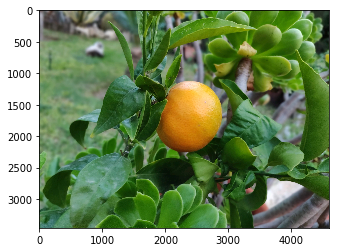

In [2]:
im = cv2.imread('photos/IMG_20181116_174045_Bokeh.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
im = cv2.cvtColor(im, cv2.COLOR_RGB2LAB) 

print(im[:, :, 0].max(), im[:, :, 1].max(), im[:, :, 2].max())

plt.imshow(im)
plt.show()

im = cv2.cvtColor(im, cv2.COLOR_LAB2RGB) 

print(im[:, :, 0].max(), im[:, :, 1].max(), im[:, :, 2].max())

plt.imshow(im)
plt.show()

In [3]:
class RecolorizationDataset(Dataset):
    def __init__(self, path, extension='jpg', transforms=None):
        self.transforms = transforms
        self.path = path
        self.image_path_list = glob.glob(f"{path}/*.{extension}")
        
    def __getitem__(self, index):
        data = Image.open(self.image_path_list[index])
        
        # common data transforms
        if self.transforms is not None:
            data = self.transforms(data)  
        data = data.convert('RGB')
        
        # data to numpy for color conversions        
        data_gray = data.convert('L').convert('RGB')
        
        data_np = np.array(data)
        data_np = cv2.cvtColor(data_np, cv2.COLOR_RGB2LAB)
        data_lab = Image.fromarray(data_np.astype('uint8'))
            
        to_tensor = transforms.ToTensor()
            
        return to_tensor(data_gray), to_tensor(data_lab)

    def __len__(self):
        return len(self.image_path_list)

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256)
])

image_transforms_fullsize = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512)
])

dataset = RecolorizationDataset('./photos', transforms=image_transforms, extension='jpg')
loader = DataLoader(dataset, batch_size=6, shuffle=True)

dataset_fullsize = RecolorizationDataset('./photos', transforms=image_transforms_fullsize, extension='jpg')
loader_fullsize = DataLoader(dataset_fullsize, batch_size=6)

In [5]:
def lab_2_rgb(img):
    return cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_LAB2RGB)

torch.Size([6, 3, 256, 256]) torch.Size([6, 3, 256, 256])
1.0 0.7490196 0.8117647


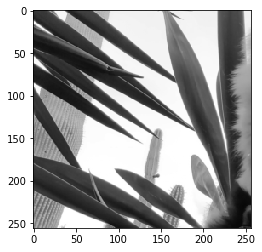

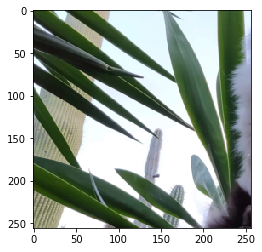

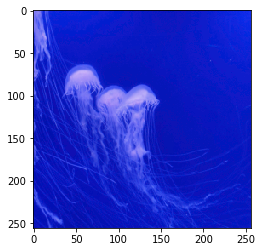

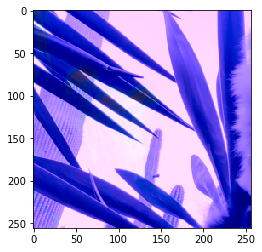

In [6]:
images_gray, images_lab = next(iter(loader))
print(images_gray.shape, images_lab.shape)

images_gray = images_gray.transpose(1, 2).transpose(2, 3).numpy()
images_lab = images_lab.transpose(1, 2).transpose(2, 3).numpy()
print(images_lab[:, :, :, 0].max(), images_lab[:, :, :, 1].max(), images_lab[:, :, :, 2].max())

plt.imshow(images_gray[0])
plt.show()

plt.imshow(lab_2_rgb(images_lab[0])) #lab_2_rgb(images_lab[0]))
plt.show()

plt.imshow(lab_2_rgb(images_lab[1]))
plt.show()

combined = np.zeros(images_lab[0].shape, dtype=np.float32)
combined[:,:,0] = images_lab[0][:,:,0]
combined[:,:,1] = images_lab[1][:,:,1]
combined[:,:,2] = images_lab[1][:,:,2]

plt.imshow(lab_2_rgb(combined))
plt.show()

In [7]:
class SimpleColorizationModel(nn.Module):
    def __init__(self):
        super(SimpleColorizationModel, self).__init__()
        
        vgg = models.vgg11_bn(pretrained=True)
        self.feature_extractor = vgg.features
        
        self.feature_list = {
            '6': 'feature_2', # ReLU2_2_1
            '10': 'feature_1', # ReLU2_3_1
            '20': 'content' # Conv2d_4_2   
        }
        
        self.decode_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        
        self.decode_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        
        self.decode_3 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        
        self.decode_final = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1)),
            nn.Sigmoid()
        )
        
    def extract_features(self, x):
        features = {}
        for name, layer in self.feature_extractor._modules.items():
            x = layer(x)
            if name in self.feature_list.keys():
                features[self.feature_list[name]] = x
                
        return features
    
    def decode(self, features):
        x = features['content']
        x = self.decode_1(x)
        x = torch.cat((x, features['feature_1']), 1)
        x = self.decode_2(x)
        x = torch.cat((x, features['feature_2']), 1)
        x = self.decode_3(x)
        x = self.decode_final(x)
        return x
        
    def forward(self, x):
        features = self.extract_features(x)
        decoded = self.decode(features)
        return decoded

In [197]:
simpleColorizationModel = SimpleColorizationModel()
simpleColorizationModel

SimpleColorizationModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Max

In [9]:
class TVLoss(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(TVLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,1:])
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]

In [10]:
def whiten(feature):
    feature = feature.unsqueeze(0)
    shape = feature.shape
    flattened = feature.view(shape[1], shape[2]*shape[3])
    
    mean = torch.mean(flattened, 1).unsqueeze(1).expand_as(flattened)
    flattened = flattened - mean
    
    cov_matrix = torch.mm(flattened, flattened.t()).div((shape[2]*shape[3]) - 1)
    
    U, E, V = torch.svd(cov_matrix, some=False) # singular value decomposition
    D = torch.pow(E, -0.5)
    
    w_step1 = torch.mm(V, torch.diag(D))
    w_step2 = torch.mm(w_step1, V.t())
    whitened = torch.mm(w_step2, flattened).view(shape)
    
    return whitened

def recolor(whitened, feature):
    feature = feature.unsqueeze(0)
    shape = feature.shape
    flattened = feature.view(shape[1], shape[2]*shape[3])
    w_flattened = whitened.view(shape[1], shape[2]*shape[3])
    
    mean = torch.mean(flattened, 1).unsqueeze(1).expand_as(flattened)
    flattened = flattened - mean
    
    cov_matrix = torch.mm(flattened, flattened.t()).div((shape[2]*shape[3]) - 1)
    
    U, E, V = torch.svd(cov_matrix, some=False) # singular value decomposition
    D = torch.pow(E, 0.5)
    
    c_step1 = torch.mm(V, torch.diag(D))
    c_step2 = torch.mm(c_step1, V.t())
    colored = torch.mm(c_step2, w_flattened) + mean
    colored = colored.view(shape)
    
    colored = colored.squeeze(0)
        
    return colored

def batch_gram_matrix(features):
    shape = features.shape
    flattened = features.view(shape[0], shape[1], shape[2]*shape[3])
    gram_matrix = torch.bmm(flattened, flattened.transpose(2, 1))
    
    return gram_matrix

In [198]:
epochs = 30

for param in simpleColorizationModel.feature_extractor.parameters():
    param.requires_grad = False

dec_criterion = nn.MSELoss()
tv_criterion = TVLoss()
optimizer = optim.SGD([
    {'params': simpleColorizationModel.decode_1.parameters()},
    {'params': simpleColorizationModel.decode_2.parameters()},
    {'params': simpleColorizationModel.decode_3.parameters()},
    {'params': simpleColorizationModel.decode_final.parameters()}
], lr=0.001, momentum=0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

decoding_weight = 0
total_variation_weight = 0
content_weight = 1e2
features_weight = [0, 0]

simpleColorizationModel.train()
for e in range(1, epochs+1):
    total_loss = 0
    tv_total_loss = 0
    dec_total_loss = 0
    content_total_loss = 0
    features_total_loss = 0
    batch_count = 0
    print(f"EPOCH {e} ...", end='\r')
    for images_gray, images_lab in loader:
        batch_count += 1
        expected = images_lab[:,1:,:,:]
        
        optimizer.zero_grad()
        
        bw_features = simpleColorizationModel.extract_features(images_gray) 
        lab_features = simpleColorizationModel.extract_features(images_lab) 
        
        # def whiten_and_recolor(feature_name):
        #    for idx, feat in enumerate(bw_features[feature_name]): 
        #        bw_features[feature_name][idx] = recolor(whiten(bw_features[feature_name][idx]), lab_features[feature_name][idx])
            
        # whiten_and_recolor('feature_1')
        # whiten_and_recolor('feature_2')
        
        pred = simpleColorizationModel.decode(bw_features)
        
        reconstructed = torch.cat((images_gray[:,0,:,:].unsqueeze(1), pred), 1)
        pred_features = simpleColorizationModel.extract_features(reconstructed) 
            
        # feature_loss = 0
        # feature_loss += dec_criterion(batch_gram_matrix(pred_features['feature_1']), batch_gram_matrix(lab_features['feature_1'])) * features_weight[0]
        # feature_loss += dec_criterion(batch_gram_matrix(pred_features['feature_2']), batch_gram_matrix(lab_features['feature_2'])) * features_weight[1]
            
        content_loss = dec_criterion(pred_features['content'], bw_features['content']) * content_weight 
        content_loss += dec_criterion(pred_features['feature_1'], lab_features['feature_1']) * content_weight / 10
        content_loss += dec_criterion(pred_features['feature_2'], lab_features['feature_2']) * content_weight / 10
        
        # dec_loss = dec_criterion(pred, expected) * decoding_weight
        # tv_loss = tv_criterion(pred) * total_variation_weight
        
        loss = content_loss # dec_loss + tv_loss + content_loss + feature_loss
    
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        # tv_total_loss += tv_loss
        # dec_total_loss += dec_loss
        # content_total_loss += content_loss
        # features_total_loss += feature_loss
        
        # print(f"EPOCH {e} ({batch_count}/{len(loader)}) - loss {total_loss/batch_count:.4f} - dec_loss {dec_total_loss/batch_count:.4f} - tv_loss {tv_total_loss/batch_count:.4f}", end='\r')

    scheduler.step(total_loss)
    print(f"EPOCH {e} - loss {total_loss/len(loader):.4f}")

    # print(f"EPOCH {e} - loss {total_loss/len(loader):.4f} - dec_loss {dec_total_loss/len(loader):.4f} - tv_loss {tv_total_loss/len(loader):.4f} - content_loss {content_total_loss/len(loader):.4f} - feat_loss {features_total_loss/len(loader):.4f}")
                              

EPOCH 1 - loss 0.8479
EPOCH 2 - loss 0.7982
EPOCH 3 - loss 0.7879
EPOCH 4 - loss 0.7742
EPOCH 5 - loss 0.7520
EPOCH 6 - loss 0.7304
EPOCH 7 - loss 0.7408
EPOCH 8 - loss 0.7225
EPOCH 9 - loss 0.6925
EPOCH 10 - loss 0.6802
EPOCH 11 - loss 0.6447
EPOCH 12 - loss 0.6412
EPOCH 13 - loss 0.6074
EPOCH 14 - loss 0.6214
EPOCH 15 - loss 0.5832
EPOCH 16 - loss 0.5724
EPOCH 17 - loss 0.5488
EPOCH 18 - loss 0.5380
EPOCH 19 - loss 0.5187
EPOCH 20 - loss 0.5165
EPOCH 21 - loss 0.5153
EPOCH 22 - loss 0.4835
EPOCH 23 - loss 0.4669
EPOCH 24 - loss 0.4639
EPOCH 25 - loss 0.4672
EPOCH 26 - loss 0.4654
EPOCH 27 - loss 0.4415
EPOCH 28 - loss 0.4426
EPOCH 29 - loss 0.4242
EPOCH 30 - loss 0.4207


In [199]:
images_gray, images_lab = next(iter(loader_fullsize))

simpleColorizationModel.eval()
with torch.no_grad():
    bw_features = simpleColorizationModel.extract_features(images_gray) 
    lab_features = simpleColorizationModel.extract_features(images_lab) 
        
    def whiten_and_recolor(feature_name):
        for idx, feat in enumerate(bw_features[feature_name]): 
            bw_features[feature_name][idx] = recolor(whiten(bw_features[feature_name][idx]), lab_features[feature_name][idx])
            
    whiten_and_recolor('feature_1')
    whiten_and_recolor('feature_2')

    pred = simpleColorizationModel.decode(bw_features)

print(pred.shape)

torch.Size([6, 2, 512, 512])


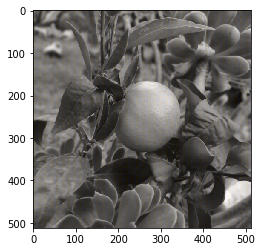

In [204]:
image_index = 2

pred_np = pred[image_index].detach().numpy().transpose(1, 2, 0)
img = images_gray[image_index].numpy().transpose(1, 2, 0)

combined = np.zeros(img.shape, dtype=np.float32)
combined[:,:,0] = img[:,:,0]
combined[:,:,1] = pred_np[:,:,0]
combined[:,:,2] = pred_np[:,:,1]

plt.imshow(lab_2_rgb(combined))
plt.show()

In [133]:
torch.save(simpleColorizationModel.state_dict(), 'model.pt')

In [140]:
checkpoint = torch.load('model.pt')
simpleColorizationModel.load_state_dict(checkpoint)